In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def L(N, D):
    """ 
    Approximates loss given N parameters and D dataset size (in tokens),
    per Chinchilla paper.
    """
    E = 1.69 # entropy of natural language, limit of infinite model on infinite data
    A = 406.4
    B = 410.7
    alpha = 0.34
    beta = 0.28
    return A / (N ** alpha) + B / (D ** beta) + E

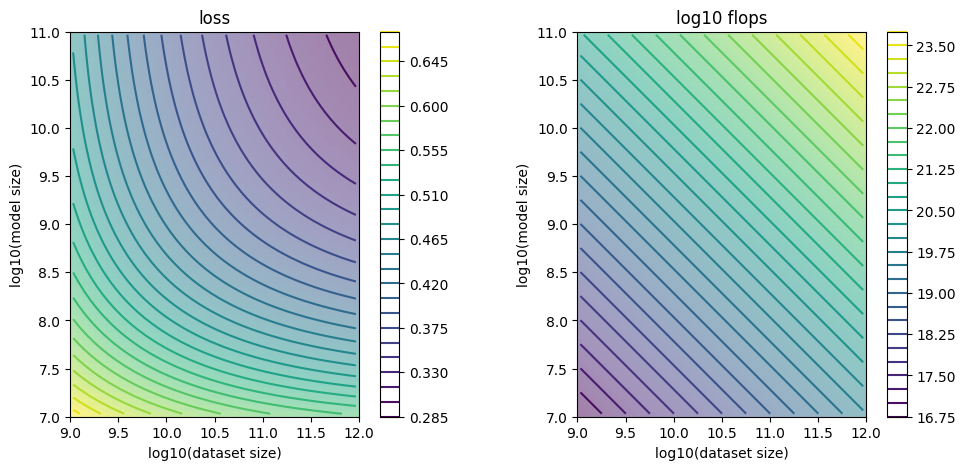

In [13]:
# Approach 3

ns = 10 ** np.arange(7, 11, step=2**-4) # model sizes from 10M to 100B
ds = 10 ** np.arange(9, 12, step=2**-4) # dataset sizes from 1B to 1T
plt.figure(figsize=(12, 5))
plt.subplot(121)
# create a 2D countour plot of loss L as a function of model size and dataset size in ns,ds
loss2d = np.log10(np.array([[L(n, d) for d in ds] for n in ns]))
plt.imshow(loss2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(loss2d, levels=30, extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('loss')
plt.colorbar()
# plot the compute for each point, which is a deterministic function: flops = 6*N*D
plt.subplot(122)
compute2d = np.log10(np.array([[6*n*d for d in ds] for n in ns]))
plt.imshow(compute2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(compute2d, levels=30, extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('log10 flops')
plt.colorbar()

best model size: 133.35M
best dataset size: 4.22B


Text(0, 0.5, 'loss')

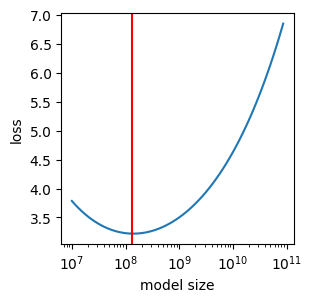

In [ ]:
# Approach 2

# c = 2.21e19 # target compute budget (usually know this because we know how many GPU for how long go brrr)
# 4 A100s for 24 hours = 1.08e20 FLOPs
c = 1.08e20 * 1/32 # 50% efficiency
# (I got this flop number from row 1 of Table A3)
# sweep model sizes from 10M to 100B
ns = 10 ** np.arange(7, 11, step=2**-4)
# using C = 6*N*D, solve for D that maintains the compute budget c
ds = c / (6 * ns)
# evaluate the loss in each case
losses = L(ns, ds)
# find the argmin
best = np.argmin(losses)
print(f"best model size: {ns[best]/1e6:.2f}M")
print(f"best dataset size: {ds[best]/1e9:.2f}B")
# plot the loss
plt.figure(figsize=(3,3))
plt.plot(ns, losses)
plt.xscale('log')
# plot a vertical bar at the best model size
plt.axvline(ns[best], color='red')
plt.xlabel('model size')
plt.ylabel('loss')

# Compute Budget Analysis (4 × A100 GPUs for 24 Hours)

Below is a breakdown of the theoretical compute budget using NVIDIA A100 (Ampere) specs. Numbers are shown for FP32, FP16/BF16 Tensor‑Core, and FP16 sparse modes.

| Precision mode                | Peak / GPU      | Total for **4 GPUs** | 24 h budget (4 GPUs × 24 h)         |
|-------------------------------|-----------------|----------------------|------------------------------------|
| FP32 (regular CUDA cores)     | **19.5 TFLOP/s** | 78 TFLOP/s           | **6.7 × 10¹⁸ FLOPs** (≈ 6.7 ExaFLOPs) |
| FP16 / BF16 **Tensor Cores**  | **312 TFLOP/s**  | 1.248 PFLOP/s        | **1.08 × 10²⁰ FLOPs** (≈ 108 ExaFLOPs) |
| FP16 sparse (2:4 sparsity)    | **624 TFLOP/s**  | 2.496 PFLOP/s        | **2.16 × 10²⁰ FLOPs** (≈ 216 ExaFLOPs) |

---

## How the numbers are computed

For any precision:
$`
\text{Total FLOPs} = N_{\text{GPU}} \times (\text{Peak TFLOP/s}) \times 10^{12} \times (\text{hours}) \times 3600
`$

Example for FP16/BF16:
$` 
4 \times 312 \times 10^{12} \text{FLOP/s} \times 24 \times 3600 = 1.08 \times 10^{20} \text{ FLOPs}.
`$

---

## Notes

- **Real‑world efficiency:** Training typically achieves only **60–70 %** of the theoretical peak due to memory bandwidth, communication overhead, and kernel inefficiencies.
- **Token throughput rule of thumb:** For transformers in FP16/BF16, approximate compute cost is **~2 × model parameters FLOPs per token** (forward + backward).
- **Sparsity caveat:** The 624 TFLOP/s number applies only with NVIDIA’s 2:4 structured sparsity kernels.

---
